In [1]:
import asyncio
import time
import logging

import vector; vector.register_awkward()

import cabinetry
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from coffea.nanoevents import NanoAODSchema
from coffea import processor
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import transforms
import awkward as ak
import numpy as np
import hist
import json
import matplotlib.pyplot as plt
import uproot

import torch
import onnx

import utils

logging.getLogger("cabinetry").setLevel(logging.INFO)

In [2]:
N_FILES_MAX_PER_SAMPLE = 10
NUM_CORES = 16
CHUNKSIZE = 500_000
IO_FILE_PERCENT = 4
USE_DASK = True
AF = "coffea_casa"

In [3]:
# functions creating systematic variations
def flat_variation(ones):
    # 0.1% weight variations
    return (1.0 + np.array([0.001, -0.001], dtype=np.float32)) * ones[:, None]


def btag_weight_variation(i_jet, jet_pt):
    # weight variation depending on i-th jet pT (10% as default value, multiplied by i-th jet pT / 50 GeV)
    return 1 + np.array([0.1, -0.1]) * (ak.singletons(jet_pt[:, i_jet]) / 50).to_numpy()


def jet_pt_resolution(pt):
    # normal distribution with 5% variations, shape matches jets
    counts = ak.num(pt)
    pt_flat = ak.flatten(pt)
    resolution_variation = np.random.normal(np.ones_like(pt_flat), 0.05)
    return ak.unflatten(resolution_variation, counts)


In [4]:
processor_base = processor.ProcessorABC
class JetClassifier(processor_base):
    def __init__(self, io_file_percent):
        self.io_file_percent = io_file_percent
    
    def process(self, events):
        
        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.
        
        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1
            
        if process == "wjets":
            events.add_systematic("scale_var", "UpDownSystematic", "weight", flat_variation)
            
        events["pt_nominal"] = 1.0
        events["pt_scale_up"] = 1.03
        events["pt_res_up"] = jet_pt_resolution(events.Jet.pt)
        
        pt_variations = ["pt_nominal", "pt_scale_up", "pt_res_up"] if variation == "nominal" else ["pt_nominal"]
        for pt_var in pt_variations:
            
            selected_electrons = events.Electron[events.Electron.pt > 30]
            selected_muons = events.Muon[events.Muon.pt > 30]
            jet_filter = events.Jet.pt * events[pt_var] > 30
            selected_jets = events.Jet[jet_filter]
            selected_genpart = events.GenPart
            
            event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
            pt_var_modifier = events[pt_var] if "res" not in pt_var else events[pt_var][jet_filter]
            event_filters = event_filters & (ak.count(selected_jets.pt * pt_var_modifier, axis=1) >= 4)
            B_TAG_THRESHOLD = 0.8
            event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)
            
            # apply event filters
            selected_events = events[event_filters]
            selected_electrons = selected_electrons[event_filters]
            selected_muons = selected_muons[event_filters]
            selected_jets = selected_jets[event_filters]
            selected_genpart = selected_genpart[event_filters]
            
            ### only consider 4j2b region
            region_filter = ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2
            selected_jets_region = selected_jets[region_filter][:,:4] # only keep top 4 jets
            selected_electrons_region = selected_electrons[region_filter]
            selected_muons_region = selected_muons[region_filter]
            selected_genpart_region = selected_genpart[region_filter]
            
            ## filter genParticles to "matchable" particles
            # make sure parent is not None
            genpart_parent = selected_genpart_region.distinctParent
            genpart_filter = np.invert(ak.is_none(genpart_parent, axis=1))
            selected_genpart_region_reduced = selected_genpart_region[genpart_filter]
            genpart_parent_reduced = selected_genpart_region_reduced.distinctParent

            # parent must be top quark or W boson
            genpart_filter2 = ((np.abs(genpart_parent_reduced.pdgId)==6) | 
                               (np.abs(genpart_parent_reduced.pdgId)==24))
            selected_genpart_region_reduced = selected_genpart_region_reduced[genpart_filter2]

            # make sure particle is a quark
            genpart_filter3 = ((np.abs(selected_genpart_region_reduced.pdgId)<9) & 
                               (np.abs(selected_genpart_region_reduced.pdgId)>0))
            selected_genpart_region_reduced = selected_genpart_region_reduced[genpart_filter3]

            # get rid of copies
            genpart_filter4 = selected_genpart_region_reduced.hasFlags("isLastCopy")
            selected_genpart_region_reduced = selected_genpart_region_reduced[genpart_filter4]
            
            nearest_genpart = selected_jets_region.nearest(selected_genpart_region_reduced, 
                                               threshold=0.4)
            
            labels = nearest_genpart.distinctParent.pdgId
            
            # calculate labels
            counts = ak.num(labels)
            labels_flat = np.abs(ak.flatten(labels).to_numpy())
            labels_flat[(labels_flat!=6)&(labels_flat!=24)]=0 # other
            labels_flat[(labels_flat==6)]=1 # top quark
            labels_flat[(labels_flat==24)]=2 # W boson
            labels = ak.unflatten(labels_flat, counts)
            labels = ak.fill_none(labels,0)
            
            jet_truth_filter = ((ak.sum(labels==1, axis=-1)==2) & 
                                (ak.sum(labels==2, axis=-1)==2))
            
            selected_jets_region = selected_jets_region[jet_truth_filter]
            selected_electrons_region = selected_electrons_region[jet_truth_filter]
            selected_muons_region = selected_muons_region[jet_truth_filter]
            labels = labels[jet_truth_filter]
            
            
            mass_0_1 = (selected_jets_region[:,0] + selected_jets_region[:,1]).mass
            mass_0_2 = (selected_jets_region[:,0] + selected_jets_region[:,2]).mass
            mass_0_3 = (selected_jets_region[:,0] + selected_jets_region[:,3]).mass
            mass_1_2 = (selected_jets_region[:,1] + selected_jets_region[:,2]).mass
            mass_1_3 = (selected_jets_region[:,1] + selected_jets_region[:,3]).mass
            mass_2_3 = (selected_jets_region[:,2] + selected_jets_region[:,3]).mass
            mass_diag = ak.zeros_like(mass_0_1)

            masspairs_0 = np.vstack((mass_diag, mass_0_1,  mass_0_2,  mass_0_3 )).to_numpy().T
            masspairs_1 = np.vstack((mass_0_1,  mass_diag, mass_1_2,  mass_1_3 )).to_numpy().T
            masspairs_2 = np.vstack((mass_0_2,  mass_1_2,  mass_diag, mass_2_3 )).to_numpy().T
            masspairs_3 = np.vstack((mass_0_3,  mass_1_3,  mass_2_3,  mass_diag)).to_numpy().T

            masspairs = np.stack((masspairs_0,masspairs_1,masspairs_2,masspairs_3),axis=-1)

            deltar_0_1 = np.sqrt((selected_jets_region[:,0].phi-selected_jets_region[:,1].phi)**2 + 
                                 (selected_jets_region[:,0].eta-selected_jets_region[:,1].eta)**2)
            deltar_0_2 = np.sqrt((selected_jets_region[:,0].phi-selected_jets_region[:,2].phi)**2 + 
                                 (selected_jets_region[:,0].eta-selected_jets_region[:,2].eta)**2)
            deltar_0_3 = np.sqrt((selected_jets_region[:,0].phi-selected_jets_region[:,3].phi)**2 + 
                                 (selected_jets_region[:,0].eta-selected_jets_region[:,3].eta)**2)
            deltar_1_2 = np.sqrt((selected_jets_region[:,1].phi-selected_jets_region[:,2].phi)**2 + 
                                 (selected_jets_region[:,1].eta-selected_jets_region[:,2].eta)**2)
            deltar_1_3 = np.sqrt((selected_jets_region[:,1].phi-selected_jets_region[:,3].phi)**2 + 
                                 (selected_jets_region[:,1].eta-selected_jets_region[:,3].eta)**2)
            deltar_2_3 = np.sqrt((selected_jets_region[:,2].phi-selected_jets_region[:,3].phi)**2 + 
                                 (selected_jets_region[:,2].eta-selected_jets_region[:,3].eta)**2)
            deltar_diag = ak.zeros_like(mass_0_1)

            deltarpairs_0 = np.vstack((deltar_diag, deltar_0_1,  deltar_0_2,  deltar_0_3 )).to_numpy().T
            deltarpairs_1 = np.vstack((deltar_0_1,  deltar_diag, deltar_1_2,  deltar_1_3 )).to_numpy().T
            deltarpairs_2 = np.vstack((deltar_0_2,  deltar_1_2,  deltar_diag, deltar_2_3 )).to_numpy().T
            deltarpairs_3 = np.vstack((deltar_0_3,  deltar_1_3,  deltar_2_3,  deltar_diag)).to_numpy().T

            deltarpairs = np.stack((deltarpairs_0,deltarpairs_1,deltarpairs_2,deltarpairs_3),axis=-1)
            
            deltaphi_0_1 = np.abs(selected_jets_region[:,0].phi-selected_jets_region[:,1].phi)
            deltaphi_0_2 = np.abs(selected_jets_region[:,0].phi-selected_jets_region[:,2].phi)
            deltaphi_0_3 = np.abs(selected_jets_region[:,0].phi-selected_jets_region[:,3].phi)
            deltaphi_1_2 = np.abs(selected_jets_region[:,1].phi-selected_jets_region[:,2].phi)
            deltaphi_1_3 = np.abs(selected_jets_region[:,1].phi-selected_jets_region[:,3].phi)
            deltaphi_2_3 = np.abs(selected_jets_region[:,2].phi-selected_jets_region[:,3].phi)
            deltaphi_diag = ak.zeros_like(mass_0_1)

            deltaphipairs_0 = np.vstack((deltaphi_diag, deltaphi_0_1,  deltaphi_0_2,  deltaphi_0_3 )).to_numpy().T
            deltaphipairs_1 = np.vstack((deltaphi_0_1,  deltaphi_diag, deltaphi_1_2,  deltaphi_1_3 )).to_numpy().T
            deltaphipairs_2 = np.vstack((deltaphi_0_2,  deltaphi_1_2,  deltaphi_diag, deltaphi_2_3 )).to_numpy().T
            deltaphipairs_3 = np.vstack((deltaphi_0_3,  deltaphi_1_3,  deltaphi_2_3,  deltaphi_diag)).to_numpy().T

            deltaphipairs = np.stack([deltaphipairs_0,deltaphipairs_1,deltaphipairs_2,deltaphipairs_3],axis=-1)
            
            deltaeta_0_1 = np.abs(selected_jets_region[:,0].eta-selected_jets_region[:,1].eta)
            deltaeta_0_2 = np.abs(selected_jets_region[:,0].eta-selected_jets_region[:,2].eta)
            deltaeta_0_3 = np.abs(selected_jets_region[:,0].eta-selected_jets_region[:,3].eta)
            deltaeta_1_2 = np.abs(selected_jets_region[:,1].eta-selected_jets_region[:,2].eta)
            deltaeta_1_3 = np.abs(selected_jets_region[:,1].eta-selected_jets_region[:,3].eta)
            deltaeta_2_3 = np.abs(selected_jets_region[:,2].eta-selected_jets_region[:,3].eta)
            deltaeta_diag = ak.zeros_like(mass_0_1)

            deltaetapairs_0 = np.vstack((deltaeta_diag, deltaeta_0_1,  deltaeta_0_2,  deltaeta_0_3)).to_numpy().T
            deltaetapairs_1 = np.vstack((deltaeta_0_1,  deltaeta_diag, deltaeta_1_2,  deltaeta_1_3)).to_numpy().T
            deltaetapairs_2 = np.vstack((deltaeta_0_2,  deltaeta_1_2,  deltaeta_diag, deltaeta_2_3)).to_numpy().T
            deltaetapairs_3 = np.vstack((deltaeta_0_3,  deltaeta_1_3,  deltaeta_2_3,  deltaeta_diag)).to_numpy().T

            deltaetapairs = np.stack([deltaetapairs_0,deltaetapairs_1,deltaetapairs_2,deltaetapairs_3],axis=-1)
            
            jet_pt = np.array(selected_jets_region.pt)
            jet_eta = np.array(selected_jets_region.eta)
            jet_phi = np.array(selected_jets_region.phi)
            jet_mass = np.array(selected_jets_region.mass)

            jet_4vec = np.stack((jet_pt,jet_eta,jet_phi,jet_mass),axis=-1)
            
            lepton_eta = ak.sum(selected_electrons_region.eta,axis=-1) + ak.sum(selected_muons_region.eta,axis=-1)
            lepton_phi = ak.sum(selected_electrons_region.pt,axis=-1) + ak.sum(selected_muons_region.phi,axis=-1)
            
            deltaphi_lepton = np.abs(selected_jets_region.phi - lepton_phi).to_numpy()
            deltaeta_lepton = np.abs(selected_jets_region.eta - lepton_eta).to_numpy()
            deltar_lepton = np.sqrt((selected_jets_region.phi - lepton_phi)**2 + 
                                    (selected_jets_region.eta - lepton_eta)**2).to_numpy()
            lepton_vars = np.stack((deltaphi_lepton, deltaeta_lepton, deltar_lepton),axis=-1)
            
            other_vars = np.stack((selected_jets_region.nConstituents.to_numpy(),
                                   selected_jets_region.btagCSVV2.to_numpy(),
                                   selected_jets_region.area.to_numpy()), 
                                  axis=-1)
            
            features = np.concatenate((masspairs, deltarpairs, deltaphipairs, 
                                       deltaetapairs, jet_4vec, lepton_vars, other_vars), axis=2)
            
        output = {"nevents": {events.metadata["dataset"]: len(events)},
                  "features": {events.metadata["dataset"]: features.tolist()},
                  "labels": {events.metadata["dataset"]: labels.to_list()}}
            
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [5]:
fileset = utils.construct_fileset(N_FILES_MAX_PER_SAMPLE, use_xcache=False, json_file = 'ntuples_nanoaod_agc.json')
fileset_keys = list(fileset.keys())
for key in fileset_keys:
    if key!="ttbar__nominal":
        fileset.pop(key)

process =  ttbar
variation =  nominal
variation =  scaledown
variation =  scaleup
variation =  ME_var
variation =  PS_var
process =  single_top_s_chan
variation =  nominal
process =  single_top_t_chan
variation =  nominal
process =  single_top_tW
variation =  nominal
variation =  scaledown
variation =  scaleup
variation =  DS
process =  wjets
variation =  nominal


In [6]:
fileset

{'ttbar__nominal': {'files': ['https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root',
   'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0001.root',
   'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0002.root',
   'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0003.root',
   'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0004.

In [7]:
schema = NanoAODSchema
# executor = processor.FuturesExecutor(workers=NUM_CORES)
executor = processor.DaskExecutor(client=utils.get_client(AF))
run = processor.Runner(executor=executor, schema=schema, savemetrics=True, metadata_cache={}, chunksize=CHUNKSIZE)

In [8]:
filemeta = run.preprocess(fileset, treename="Events")

In [9]:
output, metrics = run(fileset, 
                      "Events", 
                      processor_instance = JetClassifier(IO_FILE_PERCENT))

In [10]:
features = np.array(output['features']['ttbar__nominal'])
labels = np.array(output['labels']['ttbar__nominal'])

In [11]:
from itertools import combinations

In [12]:
mass_other = []
mass_same = []

deltar_other = []
deltar_same = []

deltaphi_other = []
deltaphi_same = []

deltaeta_other = []
deltaeta_same = []

for event in range(features.shape[0]):
    labels_permutations = np.array(list(combinations(labels[0,:],2)))
    labels_indices = np.array(list((i,j) for ((i,_),(j,_)) 
                                   in combinations(enumerate(labels[0,:]), 2)))
    sum_permutations = np.array([sum(labels_permutations[i,:]) for i in range(6)])
    
    valid_inds = np.array(labels_indices)[sum_permutations==3]
    invalid_inds = np.array(labels_indices)[sum_permutations!=3]
    
    for i in valid_inds:
        mass_other.append(features[event,i[0],i[1]])
        deltar_other.append(features[event,i[0],i[1]+4])
        deltaphi_other.append(features[event,i[0],i[1]+8])
        deltaeta_other.append(features[event,i[0],i[1]+12])
        
    for i in invalid_inds:
        mass_same.append(features[event,i[0],i[1]])
        deltar_same.append(features[event,i[0],i[1]+4])
        deltaphi_same.append(features[event,i[0],i[1]+8])
        deltaeta_same.append(features[event,i[0],i[1]+12])

In [13]:
import matplotlib.pyplot as plt

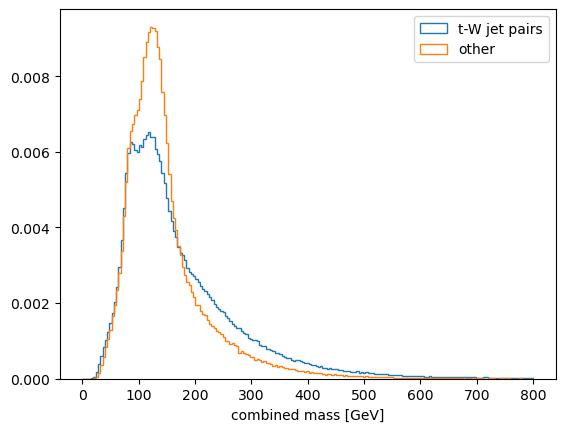

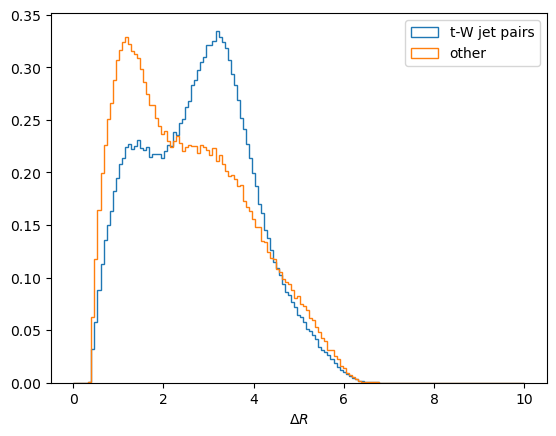

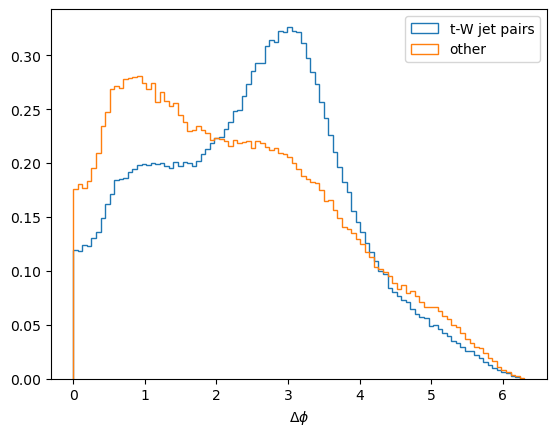

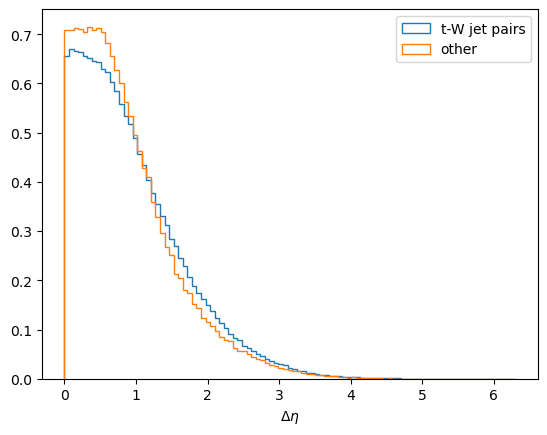

In [14]:
bins = np.linspace(0,800,200)
plt.hist(mass_other,histtype='step',bins=bins,density=True)
plt.hist(mass_same,histtype='step',bins=bins,density=True)
plt.legend(["t-W jet pairs", "other"])
plt.xlabel("combined mass [GeV]")
plt.show()

bins = np.linspace(0,10,150)
plt.hist(deltar_other,histtype='step',bins=bins,density=True)
plt.hist(deltar_same,histtype='step',bins=bins,density=True)
plt.legend(["t-W jet pairs", "other"])
plt.xlabel("$\Delta R$")
plt.show()

bins = np.linspace(0,6.3,100)
plt.hist(deltaphi_other,histtype='step',bins=bins,density=True)
plt.hist(deltaphi_same,histtype='step',bins=bins,density=True)
plt.legend(["t-W jet pairs", "other"])
plt.xlabel("$\Delta \phi$")
plt.show()

bins = np.linspace(0,6.3,100)
plt.hist(deltaeta_other,histtype='step',bins=bins,density=True)
plt.hist(deltaeta_same,histtype='step',bins=bins,density=True)
plt.legend(["t-W jet pairs", "other"])
plt.xlabel("$\Delta \eta$")
plt.show()

In [17]:
features_flat = features.reshape((features.shape[0]*features.shape[1],features.shape[2]))
labels_flat = labels.reshape((labels.shape[0]*labels.shape[1]))

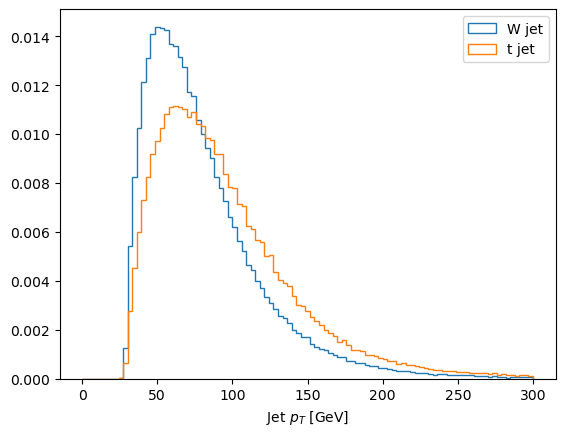

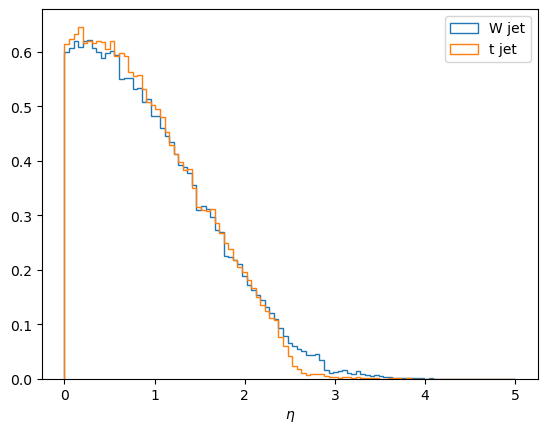

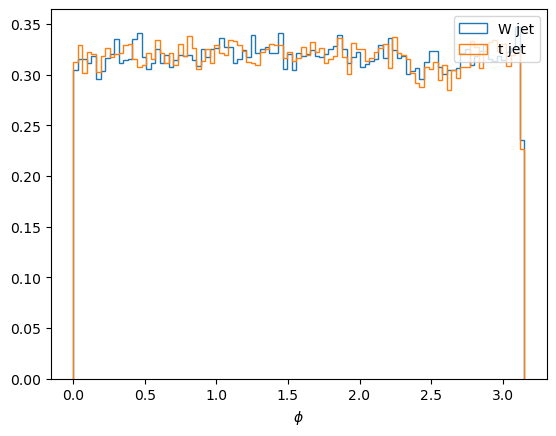

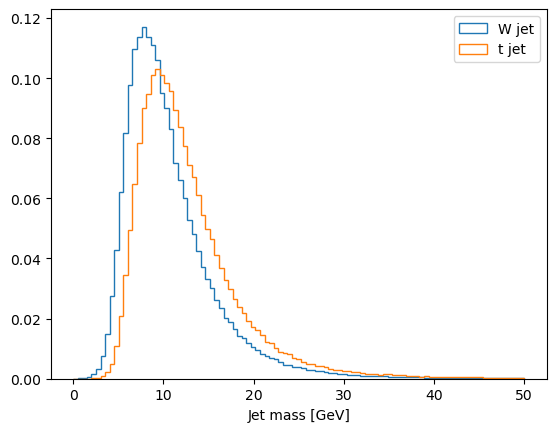

In [21]:
pt_wjet = features_flat[:,16][labels_flat==2]
pt_tjet = features_flat[:,16][labels_flat==1]

bins = np.linspace(0,300,100)
plt.hist(pt_wjet,histtype='step',bins=bins,density=True)
plt.hist(pt_tjet,histtype='step',bins=bins,density=True)
plt.legend(["W jet", "t jet"])
plt.xlabel("Jet $p_T$ [GeV]")
plt.show()

eta_wjet = features_flat[:,17][labels_flat==2]
eta_tjet = features_flat[:,17][labels_flat==1]

bins = np.linspace(0,5,100)
plt.hist(eta_wjet,histtype='step',bins=bins,density=True)
plt.hist(eta_tjet,histtype='step',bins=bins,density=True)
plt.legend(["W jet", "t jet"])
plt.xlabel("$\eta$")
plt.show()

phi_wjet = features_flat[:,18][labels_flat==2]
phi_tjet = features_flat[:,18][labels_flat==1]

bins = np.linspace(0,3.15,100)
plt.hist(phi_wjet,histtype='step',bins=bins,density=True)
plt.hist(phi_tjet,histtype='step',bins=bins,density=True)
plt.legend(["W jet", "t jet"])
plt.xlabel("$\phi$")
plt.show()

m_wjet = features_flat[:,19][labels_flat==2]
m_tjet = features_flat[:,19][labels_flat==1]

bins = np.linspace(0,50,100)
plt.hist(m_wjet,histtype='step',bins=bins,density=True)
plt.hist(m_tjet,histtype='step',bins=bins,density=True)
plt.legend(["W jet", "t jet"])
plt.xlabel("Jet mass [GeV]")
plt.show()